In [1]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBRegressor


In [2]:
DATA = Path("/Users/thetsusann/Documents/ML/Energy404---Rooftop-Solar-Potential/New_approach/dataset/cleaned_datasets/top20_balanced_sample.parquet")
df = pd.read_parquet(DATA)

TARGET = "kWh_per_m2"
CAT = ["BuildingType"]
NUM = ["tilt","tilt2","tilt_sin","tilt_cos",
       "GHI_kWh_per_m2_day","AvgTemp_C",
       "ClearnessIndex","Precip_mm_per_day"]

X = df[NUM + CAT].copy()
y = df[TARGET].copy()

for c in CAT:
    X[c] = X[c].astype("category")

y_log = np.log1p(y)
X_xgb = X.copy()
X_xgb["BuildingType"] = X_xgb["BuildingType"].cat.codes


In [3]:
xgb_params = dict(
    objective='reg:squarederror',
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_params = dict(
    objective='mae',
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=15,
    min_child_samples=100,
    lambda_l1=1.0,
    lambda_l2=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [4]:
cv = GroupKFold(n_splits=3)
fold_mae, oof_list = [], []

for fold, (tr, va) in enumerate(cv.split(X, y_log, groups=df["City"]), 1):
    X_tr_lgb, X_va_lgb = X.iloc[tr], X.iloc[va]
    X_tr_xgb, X_va_xgb = X_xgb.iloc[tr], X_xgb.iloc[va]
    y_tr, y_va = y_log.iloc[tr], y_log.iloc[va]

    # --- train base models ---
    lgb = LGBMRegressor(**lgb_params)
    xgb = XGBRegressor(**xgb_params)
    xgb.fit(X_tr_xgb, y_tr, eval_set=[(X_va_xgb, y_va)], verbose=False)
    lgb.fit(X_tr_lgb, y_tr, eval_set=[(X_va_lgb, y_va)],
            callbacks=[early_stopping(stopping_rounds=150, verbose=False)])

    # --- OOF predictions ---
    pred_xgb = np.expm1(xgb.predict(X_va_xgb))
    pred_lgb = np.expm1(lgb.predict(X_va_lgb))
    meta = Ridge(alpha=1.0)
    meta.fit(np.column_stack([pred_xgb, pred_lgb]), np.expm1(y_va))
    stacked_pred = meta.predict(np.column_stack([pred_xgb, pred_lgb]))

    # --- record residuals for this fold ---
    oof_fold = pd.DataFrame({
    "City": df.loc[va, "City"].values,
    "BuildingType": df.loc[va, "BuildingType"].values,
    "y_true": np.expm1(y_va),
    "y_pred_raw": stacked_pred
})


    # --- compute bias on training cities ---
    train_pred = np.expm1(meta.predict(np.column_stack([
        np.expm1(xgb.predict(X_tr_xgb)),
        np.expm1(lgb.predict(X_tr_lgb))
    ])))
    train_df = pd.DataFrame({
        "City": df.loc[tr, "City"].values,
        "residual": np.expm1(y_tr) - train_pred
    })
    bias_train = train_df.groupby("City")["residual"].mean()

    # --- apply bias safely ---
    oof_fold["bias_value"] = oof_fold["City"].map(bias_train).fillna(0)
    oof_fold["y_pred_biascorr"] = oof_fold["y_pred_raw"] + oof_fold["bias_value"]

    # --- evaluate ---
    mae_raw  = mean_absolute_error(oof_fold["y_true"], oof_fold["y_pred_raw"])
    mae_corr = mean_absolute_error(oof_fold["y_true"], oof_fold["y_pred_biascorr"])
    print(f"Fold {fold}: MAE raw={mae_raw:.3f}, bias-corrected={mae_corr:.3f}")

    oof_list.append(oof_fold)

# Combine folds
oof_df = pd.concat(oof_list, ignore_index=True)
mae_before = mean_absolute_error(oof_df["y_true"], oof_df["y_pred_raw"])
mae_after  = mean_absolute_error(oof_df["y_true"], oof_df["y_pred_biascorr"])
print(f"\n🎯 Overall MAE before correction: {mae_before:.3f}")
print(f"🎯 Overall MAE after correction:  {mae_after:.3f}")


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 623077, number of used features: 9
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Start tr

=== Mean Bias (True - Pred) by Building Type ===
BuildingType
small commercial            -11.04
single family residential    -1.31
multifamily residential      -1.20
public sector                -0.51
industrial                    0.20
commercial                    0.86
hotels                        8.26
schools                       9.40
public health facilities     10.17
peri-urban settlement        28.09
Name: bias, dtype: float64

=== Mean Absolute Error by Building Type ===
BuildingType
small commercial             11.04
single family residential     1.31
multifamily residential       1.20
public sector                 0.51
industrial                    0.20
commercial                    0.86
hotels                        8.26
schools                       9.40
public health facilities     10.17
peri-urban settlement        28.09
Name: abs_error, dtype: float64


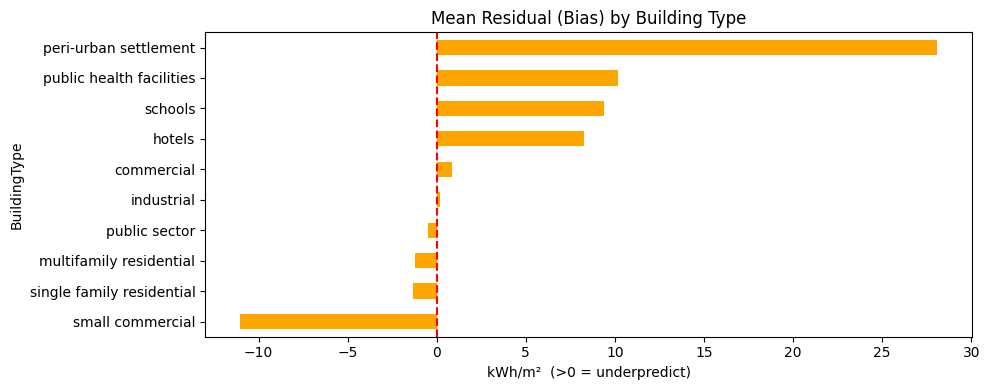

In [5]:
# === Type-level error analysis ===
type_stats = (
    oof_df.groupby("BuildingType")[["y_true", "y_pred_raw"]]
    .mean()
    .assign(
        bias=lambda d: d["y_true"] - d["y_pred_raw"],
        abs_error=lambda d: (d["y_true"] - d["y_pred_raw"]).abs()
    )
    .sort_values("bias")
)

print("=== Mean Bias (True - Pred) by Building Type ===")
print(type_stats["bias"].round(2))
print("\n=== Mean Absolute Error by Building Type ===")
print(type_stats["abs_error"].round(2))

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
type_stats["bias"].plot(kind="barh", color="orange")
plt.axvline(0, color="red", ls="--")
plt.title("Mean Residual (Bias) by Building Type")
plt.xlabel("kWh/m²  (>0 = underpredict)")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import mean_absolute_error

cv = GroupKFold(n_splits=3)
oof_list = []

for fold, (tr, va) in enumerate(cv.split(X, y_log, groups=df["City"]), 1):
    # Split data
    X_tr_lgb, X_va_lgb = X.iloc[tr], X.iloc[va]
    X_tr_xgb, X_va_xgb = X_xgb.iloc[tr], X_xgb.iloc[va]
    y_tr, y_va = y_log.iloc[tr], y_log.iloc[va]

    # Train base models
    lgb = LGBMRegressor(**lgb_params)
    xgb = XGBRegressor(**xgb_params)
    xgb.fit(X_tr_xgb, y_tr, eval_set=[(X_va_xgb, y_va)], verbose=False)
    lgb.fit(X_tr_lgb, y_tr, eval_set=[(X_va_lgb, y_va)],
            callbacks=[early_stopping(stopping_rounds=150, verbose=False)])

    # Out-of-fold preds
    pred_xgb = np.expm1(xgb.predict(X_va_xgb))
    pred_lgb = np.expm1(lgb.predict(X_va_lgb))
    meta = Ridge(alpha=1.0)
    meta.fit(np.column_stack([pred_xgb, pred_lgb]), np.expm1(y_va))
    stacked_pred = meta.predict(np.column_stack([pred_xgb, pred_lgb]))

    # Record residuals
    oof_fold = pd.DataFrame({
        "City": df.loc[va, "City"].values,
        "BuildingType": df.loc[va, "BuildingType"].values,
        "y_true": np.expm1(y_va),
        "y_pred_raw": stacked_pred
    })

    # --- Compute type bias on training folds (fixed) ---
    train_pred = meta.predict(np.column_stack([
        np.expm1(xgb.predict(X_tr_xgb)),
        np.expm1(lgb.predict(X_tr_lgb))
    ]))
    train_df = pd.DataFrame({
        "BuildingType": df.loc[tr, "BuildingType"].values,
        "residual": np.expm1(y_tr) - train_pred
    })
    bias_type = train_df.groupby("BuildingType")["residual"].mean()

    # --- Apply bias safely ---
    oof_fold["bias_value"] = oof_fold["BuildingType"].map(bias_type).fillna(0)
    oof_fold["y_pred_biascorr"] = oof_fold["y_pred_raw"] + oof_fold["bias_value"]

    # --- Evaluate ---
    mae_raw  = mean_absolute_error(oof_fold["y_true"], oof_fold["y_pred_raw"])
    mae_corr = mean_absolute_error(oof_fold["y_true"], oof_fold["y_pred_biascorr"])
    print(f"Fold {fold}: MAE raw={mae_raw:.3f}, bias-corrected={mae_corr:.3f}")

    oof_list.append(oof_fold)

# Combine folds
oof_type_df = pd.concat(oof_list, ignore_index=True)
mae_before = mean_absolute_error(oof_type_df["y_true"], oof_type_df["y_pred_raw"])
mae_after  = mean_absolute_error(oof_type_df["y_true"], oof_type_df["y_pred_biascorr"])

print(f"\n🎯 Overall MAE before correction: {mae_before:.3f}")
print(f"🎯 Overall MAE after correction:  {mae_after:.3f}")


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 623077, number of used features: 9
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Start tr

In [8]:
df["BuildingType"].value_counts()

BuildingType
single family residential    442224
multifamily residential      193430
commercial                   125447
public sector                 76208
industrial                    71843
peri-urban settlement         16960
schools                       14596
public health facilities       8009
hotels                         7493
small commercial               2370
Name: count, dtype: int64